In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import numpy as np
import math

import OSS as oss
import BPD as bpd
import accumulate as acc
import plotters

### Step 1: OSS

In [2]:
filepath = "ballroom.wav"
sr, data = oss.read_wav(filepath)
print(f"sampling rate: {sr}Hz")
print(f"audio length: {round(len(data)/sr, 3)} seconds")
#plot_signal(data=data, sr=sr, stop=6, title="Raw Signal")

sampling rate: 44100Hz
audio length: 31.788 seconds


calculated frame count: 10950 frames
returned frame count: 10950 frames
(10950, 256)


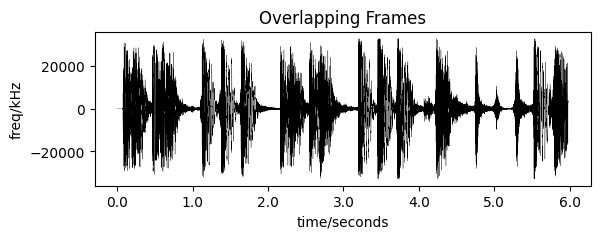

In [3]:
framesize = 256
hop = 128
print(f"calculated frame count: {1+math.floor((len(data)-framesize)/hop)} frames")
frames = oss.get_frames(data=data, framesize=framesize, hop=hop)
print(f"returned frame count: {len(frames)} frames")
frames6 = frames[:2059]
print(frames.shape)
plotters.plot_frames(frames=frames6, sr=44100, framesize=1024, hop=128, title="Overlapping Frames")

In [4]:
tappered_frames = oss.hamming_window(frames)
tappered_frames6 = oss.hamming_window(frames6)
# compute the discrete fourier transform of the frames
fft_frames = scipy.fft.fft(tappered_frames, n=framesize, axis=1)
fft_frames6 = scipy.fftpack.fft(x=tappered_frames6, n=framesize, axis=1)
fft_frames6 = abs(fft_frames6)[:,:fft_frames6.shape[1]//2 + 1]
fft_frames6 /= framesize

In [5]:
log_power = np.array(oss.comp_log_power(fft_frames))
log_power6 = np.array(oss.comp_log_power(fft_frames6))

print(fft_frames.shape)
print(fft_frames6.shape)
print(log_power.shape)
print(log_power6.shape)

diff = log_power6[0] - np.zeros(fft_frames6.shape[1])
print(diff)
diffreduced = diff[1:]
print(diffreduced)
diffclipped = diffreduced.clip(min=0)
print(diffclipped)
print(sum(diffclipped))

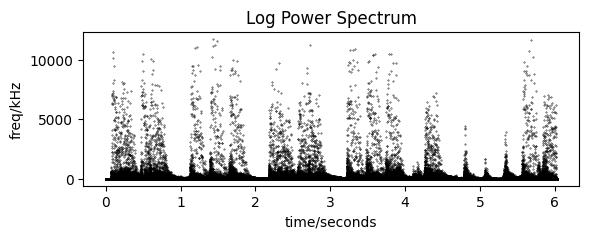

In [6]:
plotters.plot_log_spectrum(fft_frames6, framesize=framesize, hop=hop, sr=44100)

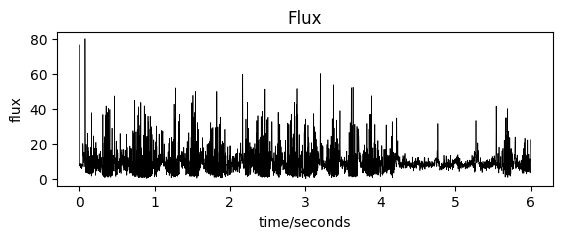

In [7]:
flux = oss.comp_flux(log_power)
flux6 = oss.comp_flux(log_power6)
plotters.plot_flux(flux6)

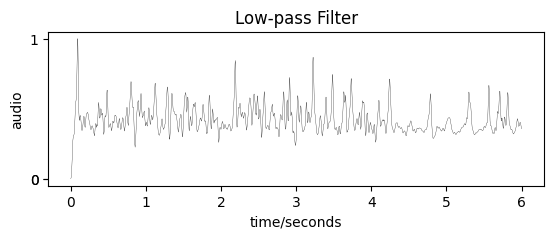

In [19]:
filtered_signal = oss.low_pass_filter(flux=flux)
filtered_signal6 = oss.low_pass_filter(flux=flux6)
plotters.plot_signal(filtered_signal6, sr=344.5, title="Low-pass Filter")

### Step 2: Beat Period Detection

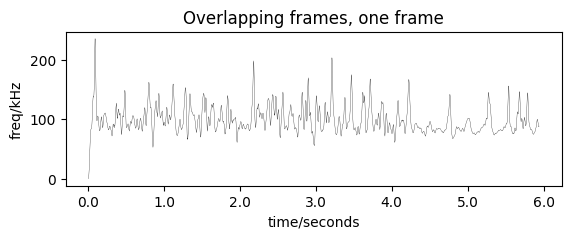

In [21]:
frames = bpd.overlap(data=filtered_signal, framesize=2048, hop=128)
plotters.plot_frames(frames=frames[0], sr=344.5, framesize=2048, hop=128, title="Overlapping frames, one frame")

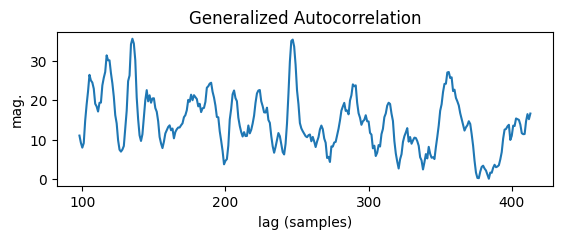

In [35]:
A = bpd.autocorrelation(signal=frames)
plotters.plot_correlation(A=A[0], title="Generalized Autocorrelation")

EAC = bpd.enhance_harmonics(A=A)
plotters.plot_correlation(A=EAC[0], title="Enhanced Harmonics")

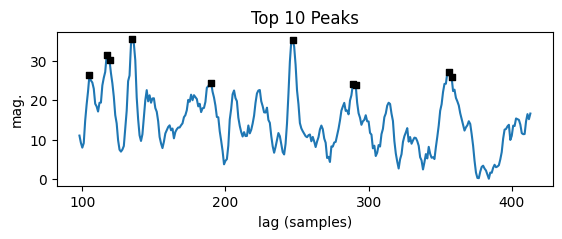

In [55]:
indices, values = bpd.pick_peaks(A=A)
idx = 0
plotters.plot_correlation(A=A[0], start=98+316*idx, stop=414+316*idx, indices=indices[idx], values=values[idx], title="Top 10 Peaks")

In [63]:
Lm = bpd.evaluate_pulse_train(indices[0], frames[0])
print(f"{int(round(344.5*60/Lm, 0))} bpm")

559 bpm


### Step 3: Accumulation and overall estimate

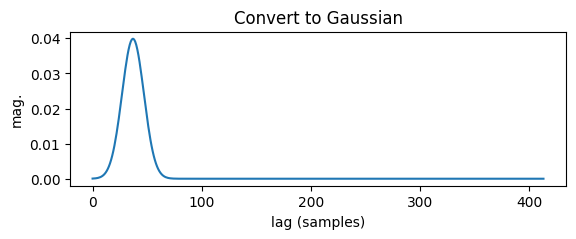

In [64]:
plotters.plot_gaussian(Lm=Lm, g=acc.Gm, title="Convert to Gaussian")

overall estimate: 94 bpm


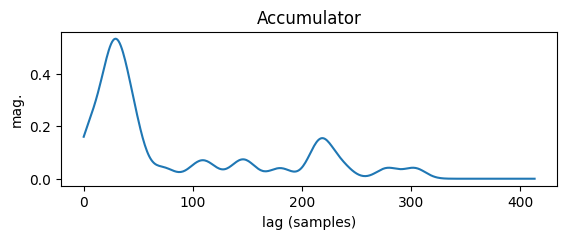

In [74]:
Lms = acc.eval_entire_signal(indices, frames)
y = acc.accumulate_gauss(Lms=Lms)
idxs, vals = bpd.find_local_maximums(np.concatenate((np.zeros(98), y[98:])))
print(f"overall estimate: {int(round(344.5*60/idxs[-1], 0))} bpm")
plotters.plot_gaussian(Lm=y, g=acc.Gm, title="Accumulator")